In [312]:
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import georasters as gr
import seaborn as sns
sns.set_theme(style="darkgrid")
import rasterio
from rasterio.plot import show
import copy
from pgmpy.models import BayesianModel
from pgmpy.estimators import BayesianEstimator
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
import networkx as nx
from time import time

In [2]:
grid_x, grid_y = np.mgrid[0:3:4j, 0:3:4j]

In [3]:
grid_x # each element signifies the row

array([[0., 0., 0., 0.],
       [1., 1., 1., 1.],
       [2., 2., 2., 2.],
       [3., 3., 3., 3.]])

In [4]:
grid_y # each elemenet signifies the col

array([[0., 1., 2., 3.],
       [0., 1., 2., 3.],
       [0., 1., 2., 3.],
       [0., 1., 2., 3.]])

In [5]:
points = np.array([[0, 0], [1, 0], [2, 0], [3, 0]])
points.shape

(4, 2)

In [6]:
values = np.array([0, 1, 2, 3])
values.shape

(4,)

In [7]:
x_min, x_max, y_min, y_max, nx, ny = 0, 3, 0, 3, 4, 4
x = np.linspace(x_min, x_max, nx)
y = np.linspace(y_min, y_max, ny)
xv, yv = np.meshgrid(x, y)

In [8]:
print(x)
print(y)

[0. 1. 2. 3.]
[0. 1. 2. 3.]


In [9]:
print(xv)
print(grid_x)

[[0. 1. 2. 3.]
 [0. 1. 2. 3.]
 [0. 1. 2. 3.]
 [0. 1. 2. 3.]]
[[0. 0. 0. 0.]
 [1. 1. 1. 1.]
 [2. 2. 2. 2.]
 [3. 3. 3. 3.]]


In [10]:
print(yv)
print(grid_y)

[[0. 0. 0. 0.]
 [1. 1. 1. 1.]
 [2. 2. 2. 2.]
 [3. 3. 3. 3.]]
[[0. 1. 2. 3.]
 [0. 1. 2. 3.]
 [0. 1. 2. 3.]
 [0. 1. 2. 3.]]


# Data

In [11]:
vlm_df = pd.read_excel('../Week 5/data.xls')

elevation_file = gr.from_file('../Week 6/Elevation.tif')
elevation_df = elevation_file.to_geopandas()
dataset = rasterio.open('../Week 6/Elevation.tif')
elevation = dataset.read(1)

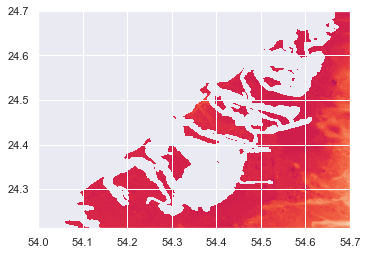

<AxesSubplot:>

In [12]:
show(dataset)

In [13]:
elevation_df.head()

,row,col,value,x,y,geometry
0,0,2347,1.0,54.651806,24.700139,"POLYGON ((54.65181 24.70014, 54.65208 24.70014..."
1,0,2348,0.0,54.652084,24.700139,"POLYGON ((54.65208 24.70014, 54.65236 24.70014..."
2,0,2349,1.0,54.652361,24.700139,"POLYGON ((54.65236 24.70014, 54.65264 24.70014..."
3,0,2350,1.0,54.652639,24.700139,"POLYGON ((54.65264 24.70014, 54.65292 24.70014..."
4,0,2351,2.0,54.652917,24.700139,"POLYGON ((54.65292 24.70014, 54.65319 24.70014..."


In [14]:
elevation_df.iloc[1737185]

row                                                      1733
col                                                      2493
value                                                    83.0
x                                                   54.692361
y                                                    24.21875
geometry    POLYGON ((54.69236140540001 24.2187497786, 54....
Name: 1737185, dtype: object

In [15]:
np.where(elevation == 83)
np.where(elevation == -89)

(array([1408]), array([2125]))

In [16]:
elevation_nan = copy.deepcopy(elevation)

elevation_nan = elevation_nan.astype('float')
elevation_nan[elevation_nan == 32767] = np.nan

In [17]:
unique, counts = np.unique(np.isnan(elevation_nan[0]), return_counts=True)
print(np.asarray((unique, counts)).T)

[[   0  169]
 [   1 2352]]


In [18]:
unique, counts = np.unique(np.isnan(elevation_nan[-1]), return_counts=True)
print(np.asarray((unique, counts)).T)

[[   0 2183]
 [   1  338]]


## Note:
<code>array.shape = (a, b)</code> = (# rows, # cols)

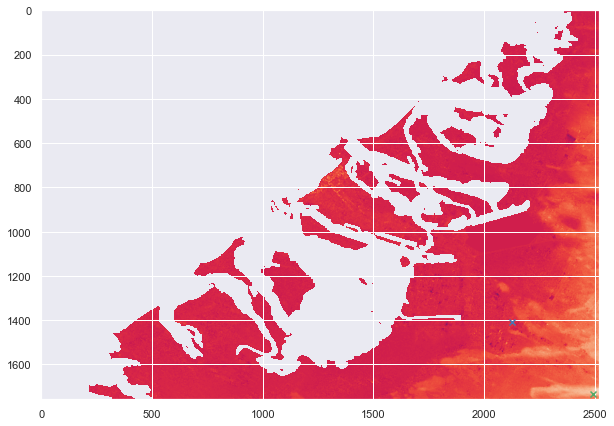

In [19]:
plt.figure(figsize=(10, 8))
plt.imshow(elevation_nan)
plt.scatter(x=2493, y=1733, c='g', marker='x')
plt.scatter(x=2125, y=1408, c='b', marker='x')
plt.show()

In [20]:
vlm = vlm_df.drop(columns=['Station', 'VLM_std'])

In [21]:
# Boundary points
# Top point: max latitude
top = vlm.iloc[vlm.idxmax().Latitude]
# Bottom point: min latitude
bottom = vlm.iloc[vlm.idxmin().Latitude]
# Left point: min longitude
left = vlm.iloc[vlm.idxmin().Longitude]
# Right point: max longitude
right = vlm.iloc[vlm.idxmax().Longitude]

In [22]:
# Artificial points for calculating distances
# point = (lon, lat)
# Top counter: lon = top, lat = bottom
top_counter = (top.Longitude, bottom.Latitude)
# Bottom counter: lon = bottom, lat = top
bottom_counter = (bottom.Longitude, top.Latitude)
# Left counter: lon = right, lat = left
left_counter = (right.Longitude, left.Latitude)
# Right counter: lon = left, lat = right
right_counter = (left.Longitude, right.Latitude)

In [23]:
# # Arrays for plotting
# top_pair = (np.array([top.Longitude, top_counter[0]]), np.array([top.Latitude, top_counter[1]]))
# bottom_pair = (np.array([bottom.Longitude, bottom_counter[0]]), np.array([bottom.Latitude, bottom_counter[1]]))
# left_pair = (np.array([left.Longitude, left_counter[0]]), np.array([left.Latitude, left_counter[1]]))
# right_pair = (np.array([right.Longitude, right_counter[0]]), np.array([right.Latitude, right_counter[1]]))

In [24]:
# sns.relplot(x="Longitude", y="Latitude", hue="VLM", data=vlm, palette="mako", height=6, aspect=1.25)
# plt.scatter(top_pair[0], top_pair[1], c='r', marker='x', s=200, alpha=0.8)
# plt.scatter(bottom_pair[0], bottom_pair[1], c='g', marker='x', s=200, alpha=0.8)
# plt.scatter(left_pair[0], left_pair[1], c='b', marker='x', s=200, alpha=0.8)
# plt.scatter(right_pair[0], right_pair[1], c='yellow', marker='x', s=200, alpha=0.8)

In [25]:
from math import radians, cos, sin, asin, sqrt
def distance(lon1, lat1, lon2, lat2):
     
    # The math module contains a function named
    # radians which converts from degrees to radians.
    lon1 = radians(lon1)
    lon2 = radians(lon2)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
      
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
 
    c = 2 * asin(sqrt(a))
    
    # Radius of earth in meters. Use 3956 for miles
    r = 6371*1000
      
    # calculate the result
    return(c * r)

In [26]:
# Distances of vertical pairs (top & bottom)
ver_top = distance(top.Longitude, top.Latitude, top_counter[0], top_counter[1])
ver_bottom = distance(bottom.Longitude, bottom.Latitude, bottom_counter[0], bottom_counter[1])
# Distances of horizontal pairs (left & right)
hor_left = distance(left.Longitude, left.Latitude, left_counter[0], left_counter[1])
hor_right = distance(right.Longitude, right.Latitude, right_counter[0], right_counter[1])

In [27]:
# There is some slight difference so I'm taking the rounded mean values
dis_ver = np.ceil(np.mean((ver_top, ver_bottom)))
dis_hor = np.ceil(np.mean((hor_left, hor_right)))

In [28]:
dis_ver, dis_hor

(119548.0, 240370.0)

In [29]:
# Boundary values
x_min, x_max = vlm.min().Longitude, vlm.max().Longitude
y_min, y_max = vlm.min().Latitude, vlm.max().Latitude

## Error found:
Originally wrote: <code>nx, ny = (np.int(np.ceil(dis_ver / 100)), np.int(np.ceil(dis_hor / 100)))</code>

Vertical distance ~ y-axis, horizontal distance ~ x-axis

In [30]:
# Divide by distance of 10m seems a bit too detailed. Trying with adding points every 100m instead
# nx, ny = (np.int(np.ceil(dis_ver / 100)), np.int(np.ceil(dis_hor / 100)))
# ABOVE IS WRONG
nx, ny = (np.int(np.ceil(dis_hor / 100)), np.int(np.ceil(dis_ver / 100)))
x = np.linspace(x_min, x_max, nx)
# y = np.linspace(y_min, y_max, ny)
y = np.linspace(y_max, y_min, ny)
xv, yv = np.meshgrid(x, y)

<ipython-input-30-3e2b024d945a>:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  nx, ny = (np.int(np.ceil(dis_hor / 100)), np.int(np.ceil(dis_ver / 100)))


In [31]:
vlm.head()

,Longitude,Latitude,VLM
0,54.684594,24.796595,-0.207
1,54.115618,24.303783,1.413
2,53.848164,24.056855,-0.856
3,53.141386,24.147625,-0.724
4,52.587928,24.171598,1.812


In [32]:
vlm_points = vlm[['Longitude', 'Latitude']].values
# vlm_points_2 = vlm[['Latitude', 'Longitude']].values
vlm_values = vlm.VLM.values

In [33]:
vlm_grid_1 = griddata(vlm_points, vlm_values, (xv, yv), method='cubic')

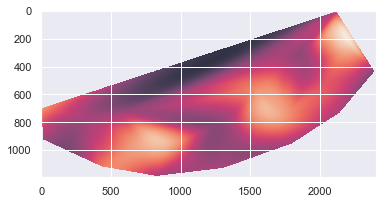

In [34]:
plt.imshow(vlm_grid_1, alpha=0.8)
plt.show()

In [35]:
vlm_inter_points = np.hstack((xv.reshape(-1, 1), yv.reshape(-1, 1)))

In [36]:
vlm_inter_values = vlm_grid_1.flatten()

In [37]:
# Find elevation map boundaries
x_min_elev = dataset.bounds.left
x_max_elev = dataset.bounds.right
y_min_elev = dataset.bounds.bottom
y_max_elev = dataset.bounds.top

# Create elevation meshgrid
nyy, nxx = elevation_nan.shape
xx = np.linspace(x_min_elev, x_max_elev, nxx)
yy = np.linspace(y_max_elev, y_min_elev, nyy)
xxv, yyv = np.meshgrid(xx, yy)

In [38]:
xxv.shape, yyv.shape

((1758, 2521), (1758, 2521))

In [39]:
vlm_grid_2 = griddata(vlm_inter_points, vlm_inter_values, (xxv, yyv), method='linear')

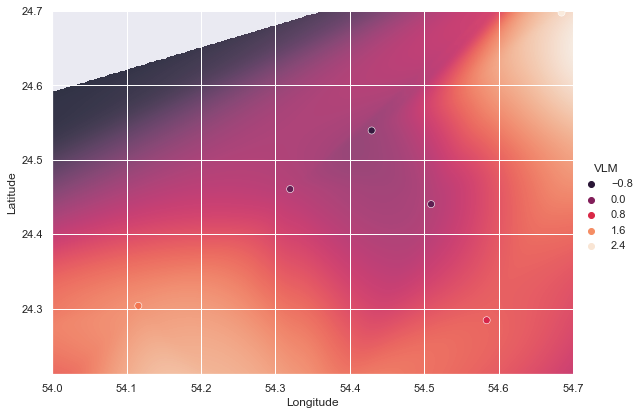

In [40]:
sns.relplot(x="Longitude", y="Latitude", hue="VLM", data=vlm, s=50, palette="rocket", height=8)
plt.imshow(vlm_grid_2, extent=(x_min_elev, x_max_elev, y_min_elev, y_max_elev), alpha=0.8)
plt.show()

In [41]:
vlm_grid_2[np.isnan(elevation_nan)] = np.nan

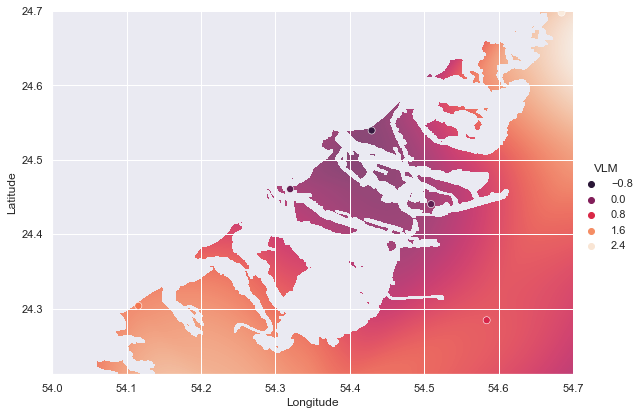

In [42]:
sns.relplot(x="Longitude", y="Latitude", hue="VLM", data=vlm, s=50, palette="rocket", height=8)
plt.imshow(vlm_grid_2, extent=(x_min_elev, x_max_elev, y_min_elev, y_max_elev), alpha=0.8)
plt.show()

In [43]:
old_vlm = np.genfromtxt('../Week 6/interpolated_vlm.csv', delimiter=',')

In [44]:
old_vlm.shape, vlm_grid_2.shape

((1758, 2521), (1758, 2521))

In [45]:
vlm_grid_3 = griddata(vlm_points, vlm_values, (xxv, yyv), method='cubic')

In [46]:
vlm_grid_3[np.isnan(elevation_nan)] = np.nan

In [47]:
vlm_grid_2[~np.isnan(vlm_grid_2)].min(), vlm_grid_2[~np.isnan(vlm_grid_2)].max()

(-2.2211921752912644, 2.8761957180469304)

In [48]:
vlm_grid_3[~np.isnan(vlm_grid_3)].min(), vlm_grid_3[~np.isnan(vlm_grid_3)].max()

(-2.2212153834176975, 2.876219936929561)

# Habitat

In [49]:
habitat_path = r"../Week 7/habitat_nearest.shp"
habitat = gpd.read_file(habitat_path)

In [50]:
habitat_groups = pd.read_excel('habitat_groups.xlsx', header=None)

In [51]:
habitat_groups.rename(columns={0: "Habitats", 1: "Groups"}, inplace=True)

In [52]:
habitat_groups.head()

,Habitats,Groups
0,Mountains,Rocky
1,Mega Dunes,Sandy
2,Marine Structure,Developed
3,Coastal Cliff,Rocky
4,Coastal Rocky Plains,Rocky


In [53]:
habitat_groups.set_index("Habitats", inplace=True)

In [54]:
habitat_groups.head()

,Groups
Habitats,
Mountains,Rocky
Mega Dunes,Sandy
Marine Structure,Developed
Coastal Cliff,Rocky
Coastal Rocky Plains,Rocky


In [55]:
habitat_new = habitat.drop(columns=["col", "index_righ", "OBJECTID", "Id", "HabitatTyp", "HabitatT_1", "HabitatSub", "HabitatS_1",
                             "RuleID", "Shape_Leng", "Shape_Area", "Habitats"], axis=1)

In [56]:
habitat_new.rename(columns={"Fill": "Habitats"}, inplace=True)

In [57]:
group_dict = habitat_groups.to_dict()['Groups']

In [58]:
habitat_new["Habitat groups"] = habitat_new["Habitats"].map(group_dict)

In [59]:
habitat_new["Habitat groups"].value_counts().sum() == habitat_new.shape[0]

True

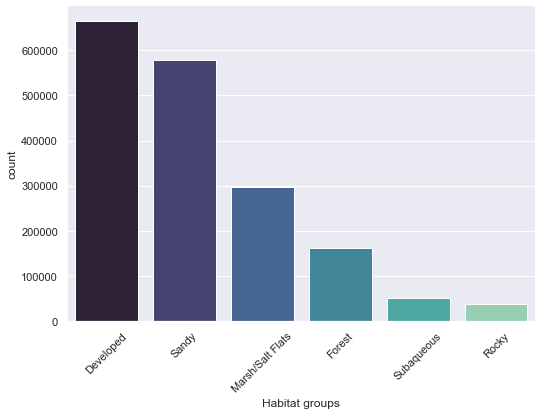

In [60]:
sns.catplot(x="Habitat groups", kind="count", palette="mako", data=habitat_new, height=5, aspect=1.5)
labels = plt.xticks(rotation=45)

In [61]:
# f, ax = plt.subplots(1, 1, figsize=(14, 10))
# ax = habitat_new.plot(column='Habitat groups', ax=ax, legend=True, cmap='magma', edgecolor="face", linewidth=0.)
# leg = ax.get_legend()
# leg.set_bbox_to_anchor((1.25, 1))
# plt.show()

# Add VLM to data

In [62]:
# First row: 2352 nan values, 169 normal values
values, counts = np.unique(~np.isnan(vlm_grid_2[0]), return_counts=True)
values, counts

(array([False,  True]), array([2352,  169]))

In [63]:
# Last row: 338 nan values, 2183 normal values
values, counts = np.unique(~np.isnan(vlm_grid_2[-1]), return_counts=True)
values, counts

(array([False,  True]), array([ 338, 2183]))

In [64]:
inter_vlm_df = pd.DataFrame(vlm_grid_2.flatten(), columns=['VLM'])
inter_vlm_df.dropna(inplace=True)
inter_vlm_df.head()

,VLM
2347,1.989310
2348,1.994643
2349,1.999969
2350,2.005187
2351,2.010404


In [65]:
habitat_new["VLM"] = inter_vlm_df.reset_index().VLM/1000

In [66]:
habitat_new['Mitigation 46-65'] = habitat_new.value - 0.27 + habitat_new.VLM

In [67]:
habitat_new['Mitigation 46-65'].describe()

count    1.789661e+06
mean     6.843349e+00
std      9.998216e+00
min     -8.926928e+01
25%      7.307857e-01
50%      2.731880e+00
75%      8.730905e+00
max      8.273014e+01
Name: Mitigation 46-65, dtype: float64

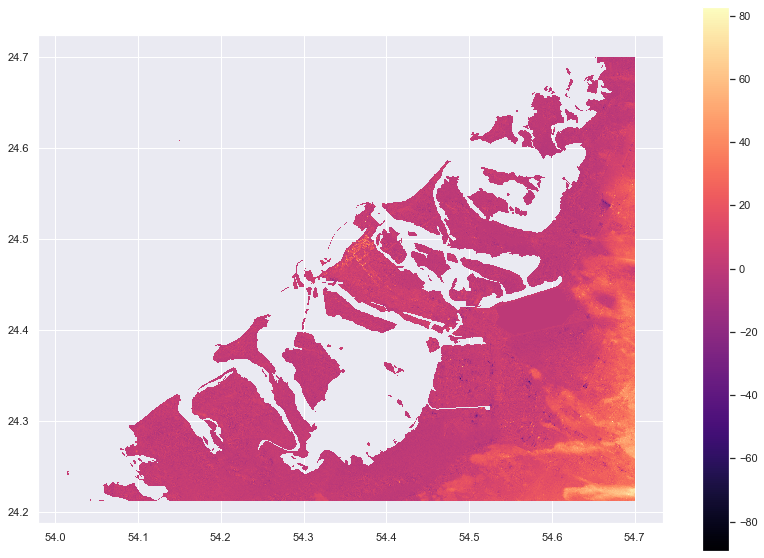

In [68]:
f, ax = plt.subplots(1, 1, figsize=(14, 10))
ax = habitat_new.plot(column='Mitigation 46-65', ax=ax, legend=True, cmap='magma', edgecolor="face", linewidth=0.)
# leg = ax.get_legend()
# leg.set_bbox_to_anchor((1.25, 1))
plt.show()

# Model

In [81]:
habitat_new.rename(columns={'value': 'Elevation'}, inplace=True)

In [82]:
habitat_new.head()

,Elevation,x,y,Habitats,geometry,Habitat groups,VLM,Mitigation 46-65
0,1.0,54.651806,24.700139,Developed,"POLYGON ((54.65181 24.70014, 54.65208 24.70014...",Developed,0.001989,0.731989
1,0.0,54.652084,24.700139,Developed,"POLYGON ((54.65208 24.70014, 54.65236 24.70014...",Developed,0.001995,-0.268005
2,1.0,54.652361,24.700139,Developed,"POLYGON ((54.65236 24.70014, 54.65264 24.70014...",Developed,0.002000,0.732000
3,1.0,54.652639,24.700139,Developed,"POLYGON ((54.65264 24.70014, 54.65292 24.70014...",Developed,0.002005,0.732005
4,2.0,54.652917,24.700139,Developed,"POLYGON ((54.65292 24.70014, 54.65319 24.70014...",Developed,0.002010,1.732010


## Elevation classes

Encoding:
- [min, -10): #0
- [-10, -1): #1
- [-1, 0): #2
- [0, 1]: #3
- (1, 5]: #4
- (5, 10]: #5
- (10, max]: #6

In [110]:
# Step 1: Create Data Frame:
elevation_classes = pd.DataFrame()
elevation_classes['Elevation_Values'] = habitat_new.Elevation

# Step 2: Get Max and Min Values for Elevation
min_elev = habitat_new.Elevation.min()
max_elev = habitat_new.Elevation.max()

# Step 3: Create Intervals:
# Intervals
interval_0 = pd.cut(x=habitat_new["Elevation"], bins=[1, 5, 10, max_elev])
interval_1 = pd.cut(x=habitat_new["Elevation"], bins=[min_elev, -10, -1, 0], right=False)
interval_2 = pd.cut(x=habitat_new["Elevation"], bins=[0, 1], include_lowest=True)
# Encoding
encoding_0 = pd.cut(x=habitat_new["Elevation"], bins=[1, 5, 10, max_elev], labels=[4, 5, 6])
encoding_1 = pd.cut(x=habitat_new["Elevation"], bins=[min_elev, -10, -1, 0], right=False, labels=[0, 1, 2])
encoding_2 = pd.cut(x=habitat_new["Elevation"], bins=[0, 1], include_lowest=True, labels=[3])


# Step 4: Add intervals to dataframe:
elevation_classes['Intervals_0'] = interval_0
elevation_classes['Intervals_1'] = interval_1
elevation_classes['Intervals_2'] = interval_2
elevation_classes['Intervals'] = ''

elevation_classes.loc[ ((elevation_classes.Intervals_0.isnull()) & (elevation_classes.Intervals_1.isnull())), 'Intervals'] = interval_2
elevation_classes.loc[ ((elevation_classes.Intervals_0.isnull()) & (elevation_classes.Intervals_2.isnull())), 'Intervals'] = interval_1
elevation_classes.loc[ ((elevation_classes.Intervals_1.isnull()) & (elevation_classes.Intervals_2.isnull())), 'Intervals'] = interval_0

# Add class encoding
elevation_classes['Encoding_0'] = encoding_0
elevation_classes['Encoding_1'] = encoding_1
elevation_classes['Encoding_2'] = encoding_2
elevation_classes['Encoding'] = ''

elevation_classes.loc[ ((elevation_classes.Encoding_0.isnull()) & (elevation_classes.Encoding_1.isnull())), 'Encoding'] = encoding_2
elevation_classes.loc[ ((elevation_classes.Encoding_0.isnull()) & (elevation_classes.Encoding_2.isnull())), 'Encoding'] = encoding_1
elevation_classes.loc[ ((elevation_classes.Encoding_1.isnull()) & (elevation_classes.Encoding_2.isnull())), 'Encoding'] = encoding_0

elevation_classes.drop(['Intervals_2', 'Intervals_1', 'Intervals_0', 'Encoding_2', 'Encoding_1', 'Encoding_0'],
                       axis='columns', inplace=True)

In [112]:
elevation_classes.head()

,Elevation_Values,Intervals,Encoding
0,1.0,"(-0.001, 1.0]",3
1,0.0,"(-0.001, 1.0]",3
2,1.0,"(-0.001, 1.0]",3
3,1.0,"(-0.001, 1.0]",3
4,2.0,"(1.0, 5.0]",4


In [115]:
elev_counts = pd.DataFrame(elevation_classes.Intervals.value_counts())
elev_counts.sort_index(inplace=True)

<AxesSubplot:ylabel='Intervals'>

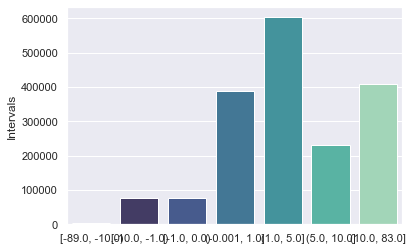

In [118]:
sns.barplot(x=elev_counts.index, y="Intervals", palette="mako", data=elev_counts)

## VLM classes

In [120]:
vlm_classes = pd.DataFrame()
vlm_classes['VLM_Values'] = habitat_new.VLM

# Intervals
vlm_intervals = pd.qcut(habitat_new.VLM, q=3)

# Encoding
vlm_encoding = pd.qcut(habitat_new.VLM, q=3, labels=[0, 1, 2])

vlm_classes['Intervals'] = vlm_intervals
vlm_classes['Encoding'] = vlm_encoding

In [122]:
vlm_classes.head()

,VLM_Values,Intervals,Encoding
0,0.001989,"(0.00102, 0.00288]",2
1,0.001995,"(0.00102, 0.00288]",2
2,0.002000,"(0.00102, 0.00288]",2
3,0.002005,"(0.00102, 0.00288]",2
4,0.002010,"(0.00102, 0.00288]",2


In [157]:
for i in range(3):
    print(i, vlm_classes[vlm_classes.Encoding == i].Intervals.iloc[i])

0 (-0.00322, 0.000517]
1 (0.000517, 0.00102]
2 (0.00102, 0.00288]


In [129]:
vlm_classes.Intervals.value_counts()

(-0.00322, 0.000517]    596554
(0.00102, 0.00288]      596554
(0.000517, 0.00102]     596553
Name: Intervals, dtype: int64

## Habitat groups

In [132]:
h_groups = ['Subaqueous', 'Rocky', 'Marsh/Salt Flats', 'Sandy', 'Forest', 'Developed']
h_encoding = [0, 1, 2, 3, 4, 5]

In [149]:
h_df = pd.DataFrame(list(zip(h_groups, h_encoding)), columns=['Habitat', 'Encoding'])
h_df.set_index('Habitat', inplace=True)
h_dict = h_df.to_dict()['Encoding']

In [153]:
h_classes = pd.DataFrame()
h_classes['Values'] = habitat_new['Habitat groups']
h_classes['Encoding'] = habitat_new['Habitat groups'].map(h_dict)

In [158]:
for i in range(6):
    print(i, h_classes[h_classes.Encoding == i].Values.iloc[i])

0 Subaqueous
1 Rocky
2 Marsh/Salt Flats
3 Sandy
4 Forest
5 Developed


## Add to dataframe

In [165]:
habitat_new.rename(columns={'VLM': 'VLM values'}, inplace=True)

In [167]:
habitat_new["E"] = elevation_classes.Encoding
habitat_new["VLM"] = vlm_classes.Encoding
habitat_new['LC'] = h_classes.Encoding

### 2046 - 2065: Mitigation (SLR = 0.27)
### Mitigation - 0, Intermediate - 1, Intermediate-high - 2, High - 3
### <code>mit0</code> = mitigation of prediction window 0

In [169]:
mit0 = habitat_new.drop(columns=["Elevation", 'Habitats', 'Habitat groups', 'VLM values'], axis=1)
mit0.head(2)

,x,y,geometry,Mitigation 46-65,E,VLM,LC
0,54.651806,24.700139,"POLYGON ((54.65181 24.70014, 54.65208 24.70014...",0.731989,3,2,5
1,54.652084,24.700139,"POLYGON ((54.65208 24.70014, 54.65236 24.70014...",-0.268005,3,2,5


Encoding:
- [min, -12): #0
- [-12, -1): #1
- [-1, 0): #2
- [0, 1]: #3
- (1, 5]: #4
- (5, 10]: #5
- (10, max]: #6

In [170]:
# Step 1: Create Data Frame:
ae_classes = pd.DataFrame()
ae_classes['Values'] = mit0['Mitigation 46-65']

# Step 2: Get Max and Min Values for Elevation
min_elev = mit0['Mitigation 46-65'].min()
max_elev = mit0['Mitigation 46-65'].max()

# Step 3: Create Intervals:
# Intervals
interval_0 = pd.cut(x=mit0['Mitigation 46-65'], bins=[1, 5, 10, max_elev])
interval_1 = pd.cut(x=mit0['Mitigation 46-65'], bins=[min_elev, -12, -1, 0], right=False)
interval_2 = pd.cut(x=mit0['Mitigation 46-65'], bins=[0, 1], include_lowest=True)
# Encoding
encoding_0 = pd.cut(x=mit0['Mitigation 46-65'], bins=[1, 5, 10, max_elev], labels=[4, 5, 6])
encoding_1 = pd.cut(x=mit0['Mitigation 46-65'], bins=[min_elev, -12, -1, 0], right=False, labels=[0, 1, 2])
encoding_2 = pd.cut(x=mit0['Mitigation 46-65'], bins=[0, 1], include_lowest=True, labels=[3])

# Step 4: Add intervals to dataframe:
ae_classes['Intervals_0'] = interval_0
ae_classes['Intervals_1'] = interval_1
ae_classes['Intervals_2'] = interval_2
ae_classes['Intervals'] = ''

ae_classes.loc[ ((ae_classes.Intervals_0.isnull()) & (ae_classes.Intervals_1.isnull())), 'Intervals'] = interval_2
ae_classes.loc[ ((ae_classes.Intervals_0.isnull()) & (ae_classes.Intervals_2.isnull())), 'Intervals'] = interval_1
ae_classes.loc[ ((ae_classes.Intervals_1.isnull()) & (ae_classes.Intervals_2.isnull())), 'Intervals'] = interval_0

# Add class encoding
ae_classes['Encoding_0'] = encoding_0
ae_classes['Encoding_1'] = encoding_1
ae_classes['Encoding_2'] = encoding_2
ae_classes['Encoding'] = ''

ae_classes.loc[ ((ae_classes.Encoding_0.isnull()) & (ae_classes.Encoding_1.isnull())), 'Encoding'] = encoding_2
ae_classes.loc[ ((ae_classes.Encoding_0.isnull()) & (ae_classes.Encoding_2.isnull())), 'Encoding'] = encoding_1
ae_classes.loc[ ((ae_classes.Encoding_1.isnull()) & (ae_classes.Encoding_2.isnull())), 'Encoding'] = encoding_0

ae_classes.drop(['Intervals_2', 'Intervals_1', 'Intervals_0', 'Encoding_2', 'Encoding_1', 'Encoding_0'],
                axis='columns', inplace=True)

In [172]:
for i in range(7):
    print(i, ae_classes[ae_classes.Encoding == i].Intervals.iloc[i])

0 [-89.269, -12.0)
1 [-12.0, -1.0)
2 [-1.0, 0.0)
3 (-0.001, 1.0]
4 (1.0, 5.0]
5 (5.0, 10.0]
6 (10.0, 82.73]


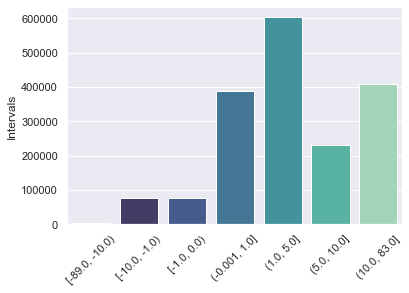

In [173]:
ae_counts = pd.DataFrame(ae_classes.Intervals.value_counts())
ae_counts.sort_index(inplace=True)
sns.barplot(x=elev_counts.index, y="Intervals", palette="mako", data=elev_counts)
labels = plt.xticks(rotation=45)

In [175]:
mit0["AE"] = ae_classes.Encoding
mit0.drop(columns=['Mitigation 46-65'], axis=1, inplace=True)

In [177]:
mit0["SLR"] = 0

## Discretization summary
- SLR: 4 classes
- VLM: 3 classes
- E: 7 classes
- LC: 6 classes
- AE: 7 classes

<img src="../Week 7/model.png"></img>

## Model

In [189]:
# model_mit = BayesianModel([('SLR', 'AE'),
#                            ('VLM', 'AE'),
#                            ('E', 'AE'),
#                            ('E', 'LC'),
#                            ('LC', 'CR'),
#                            ('AE', 'CR')])

# Creating a model without CR yet
model_mit_noCR = BayesianModel([('SLR', 'AE'),
                                ('VLM', 'AE'),
                                ('E', 'AE'),
                                ('E', 'LC')])

In [197]:
mit0_data = mit0[['SLR', 'VLM', 'E', 'LC', 'AE']]
mit0_data.head()

,SLR,VLM,E,LC,AE
0,0,2,3,5,3
1,0,2,3,5,2
2,0,2,3,5,3
3,0,2,3,5,3
4,0,2,4,5,4


In [199]:
model_mit_noCR.fit(mit0_data, estimator=BayesianEstimator, prior_type="BDeu")

In [208]:
cpds = model_mit_noCR.get_cpds()
cpds

[<TabularCPD representing P(SLR:1) at 0x7fdc2c2a8c40>,
 <TabularCPD representing P(AE:7 | E:7, SLR:1, VLM:3) at 0x7fdc2c2a88e0>,
 <TabularCPD representing P(VLM:3) at 0x7fdc2c2a8ca0>,
 <TabularCPD representing P(E:7) at 0x7fdc1bb35ee0>,
 <TabularCPD representing P(LC:6 | E:7) at 0x7fdc1bb4c0d0>]

### CR: 0 - static, 1 - dynamic
#### Try CR cpd

In [226]:
cpd_cr_df = pd.read_csv('cpd_cr.csv', header=None, index_col=0)

In [236]:
cpd_cr_df[2:]

,1,2,3,4,5,6,7,8,9,10,...,33,34,35,36,37,38,39,40,41,42
0,,,,,,,,,,,,,,,,,,,,,
CR_0,0,1,0.95,0.8,1,1,0.1,0.95,0.75,0.6,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CR_1,1,0,0.05,0.2,0,0,0.9,0.05,0.25,0.4,...,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [238]:
cpd_cr_arr = cpd_cr_df[2:].to_numpy()

In [240]:
cpd_cr_arr.shape

(2, 42)

In [241]:
cpd_cr = TabularCPD(variable='CR', variable_card=2, evidence=['AE', 'LC'], evidence_card=[7, 6], values=cpd_cr_arr)

In [244]:
cpd.cardinality

array([6, 7])

In [285]:
cpd_cr_fill_df = pd.read_csv('cpd_cr_fill.csv', header=None, index_col=0)
cpd_cr_fill_df[2:]

,1,2,3,4,5,6,7,8,9,10,...,33,34,35,36,37,38,39,40,41,42
0,,,,,,,,,,,,,,,,,,,,,
CR_0,0,1,0.95,0.8,1,1,0.1,0.95,0.75,0.6,...,0.5,0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
CR_1,1,0,0.05,0.2,0,0,0.9,0.05,0.25,0.4,...,0.5,1,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5


In [286]:
cpd_cr_fill_arr = cpd_cr_fill_df[2:].to_numpy()

In [287]:
cpd_cr_fill = TabularCPD(variable='CR', variable_card=2, evidence=['AE', 'LC'], evidence_card=[7, 6], values=cpd_cr_fill_arr)


### With CR

In [288]:
model_mit = BayesianModel([('SLR', 'AE'),
                           ('VLM', 'AE'),
                           ('E', 'AE'),
                           ('E', 'LC'),
                           ('LC', 'CR'),
                           ('AE', 'CR')])

In [289]:
mit0_data_withCR = mit0[['SLR', 'VLM', 'E', 'LC', 'AE']]
mit0_data_withCR['CR'] = 0
mit0_data_withCR.head()

<ipython-input-289-11fe2e2186ef>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mit0_data_withCR['CR'] = 0


,SLR,VLM,E,LC,AE,CR
0,0,2,3,5,3,0
1,0,2,3,5,2,0
2,0,2,3,5,3,0
3,0,2,3,5,3,0
4,0,2,4,5,4,0


In [290]:
model_mit.fit(mit0_data_withCR, estimator=BayesianEstimator, prior_type="BDeu")

In [291]:
model_mit.add_cpds(cpd_cr_fill)

In [292]:
model_mit.check_model()

True

In [448]:
model_mit.get_cpds()

[<TabularCPD representing P(SLR:1) at 0x7fdc1a5450d0>,
 <TabularCPD representing P(AE:7 | E:7, SLR:1, VLM:3) at 0x7fdc0b41fd60>,
 <TabularCPD representing P(VLM:3) at 0x7fdc0b41fac0>,
 <TabularCPD representing P(E:7) at 0x7fdc0b41fee0>,
 <TabularCPD representing P(LC:6 | E:7) at 0x7fdc2be8b6a0>,
 <TabularCPD representing P(CR:2 | AE:7, LC:6) at 0x7fdc2be81910>]

In [297]:
t = time()
pred = model_mit.predict_probability(mit0_data)
t1 = time()
print("Making prediction: %.2fs" % (t1 - t))

Making prediction: 32075.81s


In [298]:
pred

,CR_0,CR_1
0,0.50,0.50
1,0.75,0.25
2,0.50,0.50
3,0.50,0.50
4,0.25,0.75
...,...,...
1789656,0.50,0.50
1789657,0.50,0.50
1789658,0.50,0.50
1789659,0.50,0.50


In [299]:
pred.to_csv("pred_50.csv")

## <code>CR_0</code> = prob. of static, <code>CR_1</code> = prob. of dynamic

In [307]:
habitat_new["CR"] = pred["CR_1"]

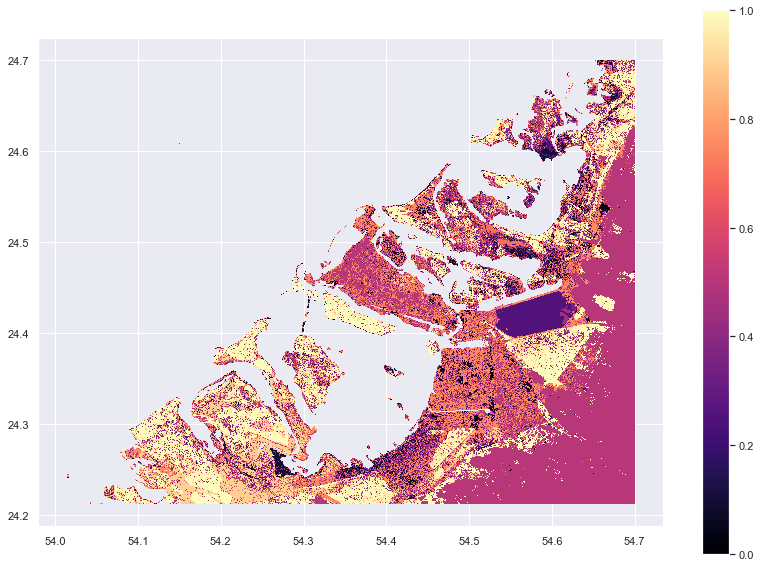

In [309]:
f, ax = plt.subplots(1, 1, figsize=(14, 10))
ax = habitat_new.plot(column='CR', ax=ax, legend=True, cmap='magma', edgecolor="face", linewidth=0.)
# leg = ax.get_legend()
# leg.set_bbox_to_anchor((1.25, 1))
plt.show()

In [314]:
from collections import defaultdict

In [317]:
missing_variables = set(model_mit.nodes()) - set(mit0_data.columns)
missing_variables

{'CR'}

In [364]:
model_inference = VariableElimination(model_mit)

In [355]:
# for _, data_point in mit0_data.iterrows():
#             full_distribution = model_inference.query(
#                 variables=missing_variables,
#                 evidence=data_point.to_dict(),
#                 show_progress=False,
#             )
#             states_dict = {}
#             for var in missing_variables:
#                 states_dict[var] = full_distribution.marginalize(
#                     missing_variables - {var}, inplace=False
#                 )
#             for k, v in states_dict.items():
#                 for l in range(len(v.values)):
#                     state = self.get_cpds(k).state_names[k][l]
#                     pred_values[k + "_" + str(state)].append(v.values[l])

In [422]:
# t0 = time()
# n = 500
# pred_values2 = defaultdict(list)
# for data_index, data_point in mit0_data[:n].iterrows():
#     dist = model_inference.query(
#                 variables=missing_variables,
#                 evidence=data_point.to_dict(), show_progress=False)
#     states_dict = {}
#     for var in missing_variables:
#         states_dict[var] = dist.marginalize(missing_variables - {var}, inplace=False)
#         for k, v in states_dict.items():
#             state = model_mit.get_cpds(k).state_names[k][1]
#             pred_values2[k + "_" + str(state)].append(v.values[1])
# #             for l in range(len(v.values)):
# #                 state = model_mit.get_cpds(k).state_names[k][l]
# #                 pred_values2[k + "_" + str(state)].append(v.values[l])
# print(f"{n} points: %.2fs" % (time() - t0))

500 points: 9.27s


In [441]:
t0 = time()
n = 500
pred_values2 = defaultdict(list)
for data_index, data_point in mit0_data[:n].iterrows():
    dist = model_inference.query(
                variables=missing_variables,
                evidence=data_point.to_dict(), show_progress=False)
#     states_dict = {}
#     states_dict['CR'] = dist.marginalize(missing_variables - {'CR'}, inplace=False)
#     pred_values2["CR_1"].append(states_dict['CR'].values[1])
print(f"{n} points: %.2fs" % (time() - t0))

500 points: 10.41s


In [438]:
pred[:500].CR_1.values == pd.DataFrame(pred_values2).CR_1.values

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [439]:
pred.shape

(1789661, 2)